In [1]:
import pandas as pd
import gdown
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np
#import os
from tqdm import tqdm
#import cv2
#from glob import glob
import seaborn as sns
sns.set()
import keras
import sklearn
import skimage
from skimage.transform import resize
import time
import random
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical


In [3]:
# downloading the image

def dowload_data(path):
    url_train='https://drive.google.com/uc?id=17Z4Ye-RhHDCzIWko2YD9vsUYVK4iy1Wu'
    url_train_labels='https://drive.google.com/uc?id=1QQ_fAhPbBjr1Yaugb3hihMAirNglCTPV'
    gdown.download(url_train,path+'xtrain.npy',quiet=None)
    gdown.download(url_train_labels,path+'ytrain.npy',quiet=None)

    url_test='https://drive.google.com/uc?id=10h1mFMXpCIk3HDI4h8i8D-mIHKF5UpXZ'
    url_test_labels='https://drive.google.com/uc?id=1KgSbhXjkcGvfz-cYTCpiHI88RCtoo6t1'
    gdown.download(url_test,path+'xtest.npy',quiet=None)
    gdown.download(url_test_labels,path+'ytest.npy',quiet=None)

    url_val='https://drive.google.com/uc?id=1Bov5cu0I5z9OrZ9_O4FK-SX19AEZM0Pa'
    url_val_labels='https://drive.google.com/uc?id=15P-JxuNLlgrI4ZZ0y1ACgs70xul0gWwx'
    gdown.download(url_val,path+'xval.npy',quiet=None)
    gdown.download(url_val_labels,path+'yval.npy',quiet=None)

path = 'C:/Users/Windows/Documents/REU/fall-2021-projects/myra-dataset/'
dowload_data(path)
    

Downloading...
From: https://drive.google.com/uc?id=17Z4Ye-RhHDCzIWko2YD9vsUYVK4iy1Wu
To: C:\Users\Windows\Documents\REU\fall-2021-projects\myra-dataset\xtrain.npy
100%|██████████| 998M/998M [00:18<00:00, 54.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1QQ_fAhPbBjr1Yaugb3hihMAirNglCTPV
To: C:\Users\Windows\Documents\REU\fall-2021-projects\myra-dataset\ytrain.npy
100%|██████████| 10.3k/10.3k [00:00<00:00, 1.28MB/s]
Downloading...
From: https://drive.google.com/uc?id=10h1mFMXpCIk3HDI4h8i8D-mIHKF5UpXZ
To: C:\Users\Windows\Documents\REU\fall-2021-projects\myra-dataset\xtest.npy
100%|██████████| 78.6M/78.6M [00:02<00:00, 37.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KgSbhXjkcGvfz-cYTCpiHI88RCtoo6t1
To: C:\Users\Windows\Documents\REU\fall-2021-projects\myra-dataset\ytest.npy
100%|██████████| 928/928 [00:00<?, ?B/s] 
Downloading...
From: https://drive.google.com/uc?id=1Bov5cu0I5z9OrZ9_O4FK-SX19AEZM0Pa
To: C:\Users\Windows\Documents\REU\fall-2021-projects\myra-da

In [4]:
root_folder = "C:/Users/Windows/Documents/REU/fall-2021-projects/myra-dataset"

X_train = np.load(root_folder+"/xtrain.npy")
y_train = np.load(root_folder+"/ytrain.npy")
X_test = np.load(root_folder+"/xtest.npy")
y_test = np.load(root_folder+"/ytest.npy")
X_val = np.load(root_folder+"/xval.npy")
y_val = np.load(root_folder+"/yval.npy")

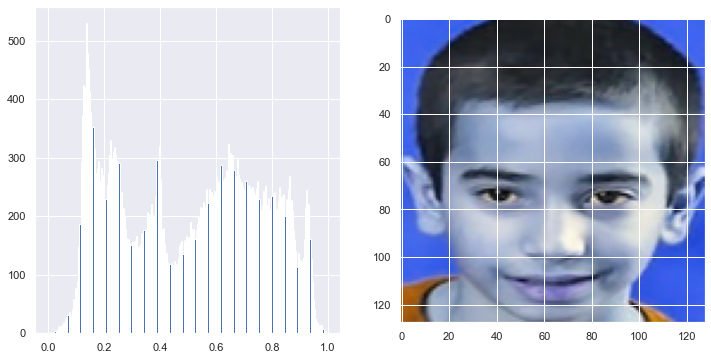

In [5]:
def plot_histogram(a):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.hist(a.ravel(),bins=255)
    plt.subplot(1,2,2)
    plt.imshow(a,vmin=0,vmax=1)
    plt.show()
    
plot_histogram(X_train[3])

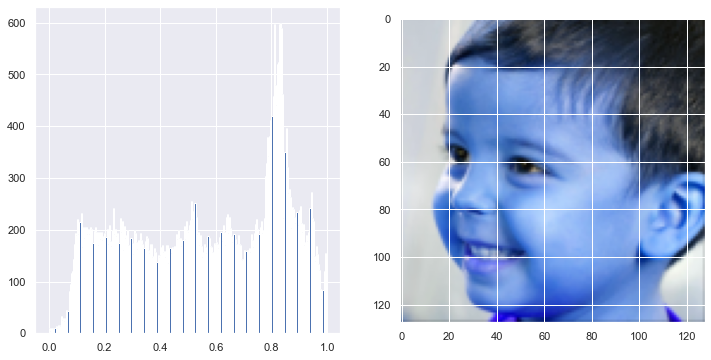

In [6]:
plot_histogram(X_test[3])

C:\Users\Windows\AppData\Roaming\Python\Python36\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='labels', ylabel='count'>

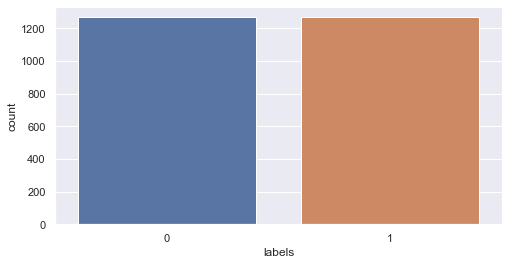

In [7]:
# Defining labels
plt.figure(figsize=(8,4))

map_characters = {0:"non_autistic",1:"autistic"}
dict_characters = map_characters

df = pd.DataFrame()
df["labels"]=y_train
lab = df["labels"]
dist=lab.value_counts()
sns.countplot(lab)

In [9]:
# Defining basic parameters
batch_size = 32
epochs = 15
num_classes = 2
n_samples, row, column, channel = X_train.shape

In [12]:

# Buidling your ResNet Model; source https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/ 
# Defining identity block

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x


In [13]:
# Code for Convolutional Block
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [23]:
#Defining ResNet34 combining the Identity and Convolutional Blocks.

def ResNet34(shape = (128, 128, 3), classes = 2):
    # Step 1 (Setup Input Layer)
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [28]:

model  = ResNet34(shape = (128, 128, 3), classes = 2)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [25]:
batch_size=32
epochs=15

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

custom_early_stopping = EarlyStopping(
    monitor='accuracy', 
    patience=50,
    restore_best_weights=True
)

In [29]:
train_Y_one_hot = to_categorical(y_train)
test_Y_one_hot = to_categorical(y_test) 
val_Y_one_hot = to_categorical(y_val)
print(train_Y_one_hot.shape)
print(val_Y_one_hot.shape)
print(val_Y_one_hot.shape)
print(X_train.shape)

history = model.fit(X_train, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=((X_val,val_Y_one_hot)))

(2538, 2)
(200, 2)
(200, 2)
(2538, 128, 128, 3)
Epoch 1/15
80/80 [==============================] - 98s 1s/step - loss: 1.4582 - accuracy: 0.5276 - val_loss: 251.3129 - val_accuracy: 0.4900
Epoch 2/15
80/80 [==============================] - 98s 1s/step - loss: 0.6808 - accuracy: 0.6044 - val_loss: 0.9058 - val_accuracy: 0.5000
Epoch 3/15
80/80 [==============================] - 101s 1s/step - loss: 0.6648 - accuracy: 0.6403 - val_loss: 8.1100 - val_accuracy: 0.5000
Epoch 4/15
80/80 [==============================] - 101s 1s/step - loss: 0.5935 - accuracy: 0.6915 - val_loss: 1.6903 - val_accuracy: 0.5300
Epoch 5/15
80/80 [==============================] - 101s 1s/step - loss: 0.5692 - accuracy: 0.7057 - val_loss: 0.8431 - val_accuracy: 0.5600
Epoch 6/15
80/80 [==============================] - 101s 1s/step - loss: 0.5515 - accuracy: 0.7262 - val_loss: 0.6680 - val_accuracy: 0.5850
Epoch 7/15
80/80 [==============================] - 101s 1s/step - loss: 0.5312 - accuracy: 0.7317 - val_l

In [30]:
# evaluating the model
test_eval = model.evaluate(X_test, test_Y_one_hot, batch_size=batch_size, verbose=1)
print("The loss of the model is {0:f}, and the accurracy is {1:f}".format(test_eval[0],test_eval[1]))

7/7 [==============================] - 1s 193ms/step - loss: 0.8761 - accuracy: 0.6100
The loss of the model is 0.876126, and the accurracy is 0.610000


In [31]:
# using fashion_trained_history information to provide the performance of the model during the training stage
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

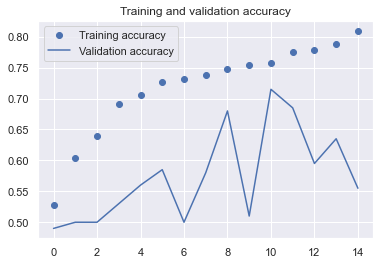

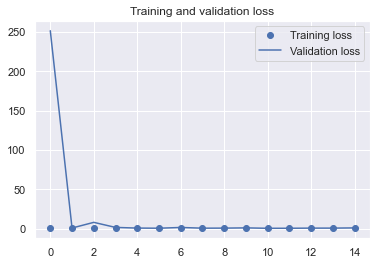

In [32]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [33]:
predicted = model.predict(X_test)

# taking the max argument
predicted = np.argmax(np.round(predicted),axis=1)
print(predicted.shape)
print(y_test.shape)

(200,)
(200,)


Found 122 correct labels


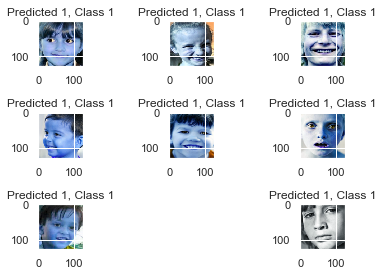

In [34]:
# Now let's select those samples that were correctly classified.
correct = np.where(predicted==y_test)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(128,128,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted[correct], y_test[correct]))
    plt.tight_layout()

Found 78 incorrect labels


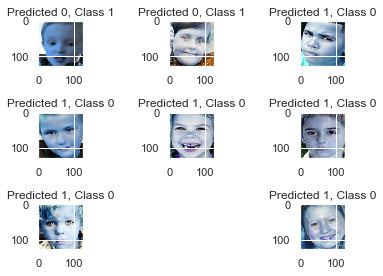

In [35]:
# Now let's select those samples that were incorrectly classified.
incorrect = np.where(predicted!=y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(128,128,3), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted[incorrect], y_test[incorrect]))
    plt.tight_layout()

In [36]:
#Printing Classification reports
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.92      0.24      0.38       100
     Class 1       0.56      0.98      0.72       100

    accuracy                           0.61       200
   macro avg       0.74      0.61      0.55       200
weighted avg       0.74      0.61      0.55       200



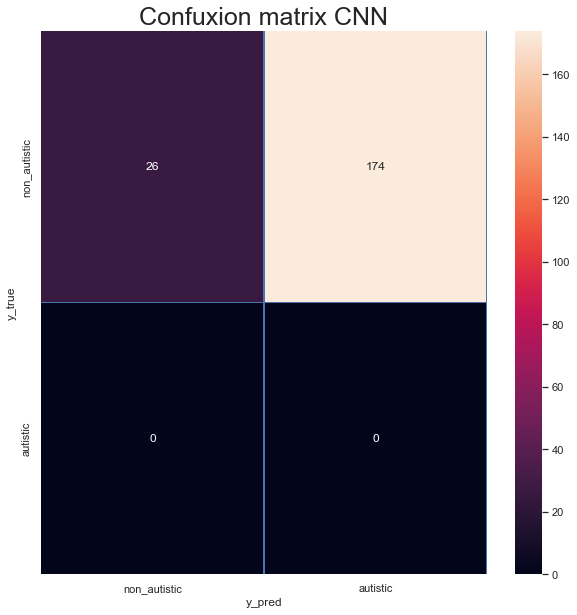

(200,)


In [38]:
# Prining confusion matrix

labels=['non_autistic','autistic']
y_classes = np.array([np.argmax(y, axis=None, out=None) for y in y_test])
cm=confusion_matrix(y_classes,predicted)
f,ax=plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="b",fmt=".0f",ax=ax)
plt.title("Confuxion matrix CNN", size = 25)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()
print(y_classes.shape)